# Data Compilation

In [79]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup

import pprintpp
pp = pprintpp.PrettyPrinter(indent=4)

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [80]:
gpt_data = pd.read_pickle("cleaned_members_gpt.pkl")
members_data = pd.read_pickle("cleaned_members_gov_uk.pkl")
votes_data = pd.read_pickle("cleaned_votes.pkl")

In [81]:
gpt_data = gpt_data.add_suffix('_gpt')
gpt_data = gpt_data.rename(columns={"id_gpt": "id"})
del gpt_data["full_title_gpt"]

members_merged = pd.merge(members_data, gpt_data, on='id', how='inner')
members_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 0 to 4520
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           4521 non-null   int64 
 1   display_name                 4521 non-null   object
 2   full_title                   4521 non-null   object
 3   gender                       4521 non-null   object
 4   member_from                  4521 non-null   object
 5   member_house                 4521 non-null   int64 
 6   membership_end_reason        4521 non-null   object
 7   membership_status            4521 non-null   object
 8   party                        4521 non-null   object
 9   party_is_lords_main          4521 non-null   object
 10  party_is_lords_spiritual     4521 non-null   object
 11  party_is_independent         4521 non-null   object
 12  membership_duration_in_days  4521 non-null   int64 
 13  member_since                 4521

In [82]:
votes_data = votes_data.rename(columns={"member_id": "id"})
votes_and_members = pd.merge(votes_data, members_merged, on='id', how='inner')
votes_and_members.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731141 entries, 0 to 731140
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           731141 non-null  object        
 1   vote_title                   731141 non-null  object        
 2   vote_date                    731141 non-null  datetime64[ns]
 3   aye_count                    731141 non-null  object        
 4   no_count                     731141 non-null  object        
 5   member_voted_aye             731141 non-null  object        
 6   vote_year                    731141 non-null  int64         
 7   vote_id                      731141 non-null  int64         
 8   vote_outcome                 731141 non-null  int64         
 9   display_name                 731141 non-null  object        
 10  full_title                   731141 non-null  object        
 11  gender                    

## Basic EDA

In [83]:
votes_and_members.duplicated().value_counts()

False    731141
dtype: int64

Each row is unique - great!

In [84]:
print("There is information on the voting patterns of", len(votes_and_members.display_name.unique()), "members in the complete dataset")
print("There is", len(votes_and_members.vote_title.unique()), "unique votes in total")
print("These votes span", len(votes_and_members.vote_year.unique()), "years, ranging from", votes_and_members.vote_year.min(), "to", votes_and_members.vote_year.max())

There is information on the voting patterns of 899 members in the complete dataset
There is 1450 unique votes in total
These votes span 8 years, ranging from 2016 to 2023


In [85]:
votes_and_members.vote_outcome.value_counts(normalize=True)

0    0.526437
1    0.473563
Name: vote_outcome, dtype: float64

The distribution of total "yay"'s vs "no"'s is pretty close, which will be good for modelling...

In [86]:
votes_and_members.member_house.value_counts(normalize=True)

1    0.978617
2    0.021383
Name: member_house, dtype: float64

97% of our members are from the House of Commons, which makes sense because that's the house that the voting data comes from... 

In [87]:
votes_and_members.gender.value_counts(normalize=True)

M    0.681163
F    0.318837
Name: gender, dtype: float64

32% of the voting data came from female members, 68% came from male members. 

In [88]:
print("Our members come from", len(votes_and_members.member_from.unique()), "constituencies, and", len(votes_and_members.party.unique()), "different parties.")

Our members come from 644 constituencies, and 16 different parties.


In [89]:
print("The party distribution:\n", votes_and_members.party.value_counts(normalize=True))

The party distribution:
 Conservative                        0.554089
Labour                              0.266594
Scottish National Party             0.054578
Labour (Co-op)                      0.038790
Independent                         0.034390
Liberal Democrat                    0.022946
Democratic Unionist Party           0.011773
Plaid Cymru                         0.004415
The Independent Group for Change    0.003467
Non-affiliated                      0.001972
Social Democratic & Labour Party    0.001796
Green Party                         0.001682
Crossbench                          0.001308
Alba Party                          0.000930
Alliance                            0.000810
Ulster Unionist Party               0.000460
Name: party, dtype: float64


Membership duration distribution: 


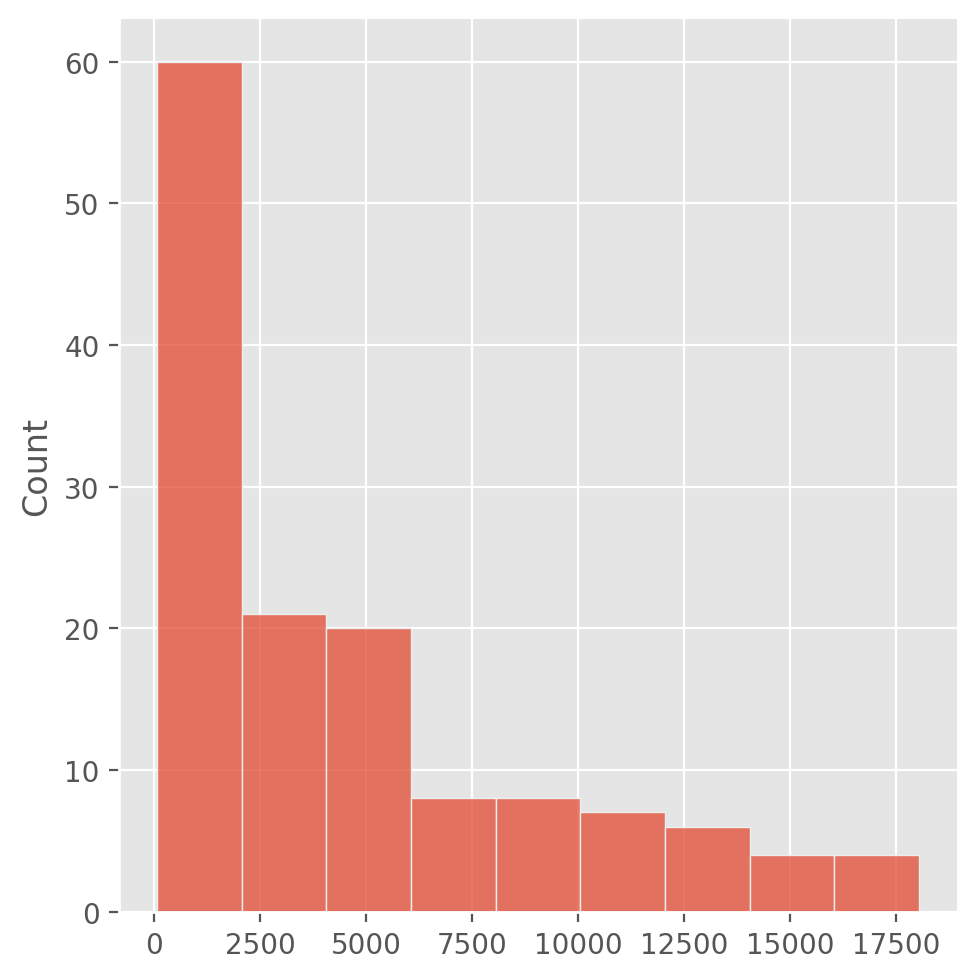

In [90]:
print("Membership duration distribution: ")
votes_and_members.membership_duration_in_days.unique()
sns.displot(votes_and_members.membership_duration_in_days.unique());

In [91]:
print("According to ChatGPT, the distribution of whether our members went to private school is as follows:\n", votes_and_members.went_private_school_gpt.value_counts(normalize=True))

According to ChatGPT, the distribution of whether our members went to private school is as follows:
 0    0.709979
1    0.288537
2    0.001484
Name: went_private_school_gpt, dtype: float64


In [92]:
print("According to ChatGPT, the proportion of our members being members of the LGBTQ+ community is as follows:\n", votes_and_members.is_part_of_lgbtq_gpt.value_counts(normalize=True))

According to ChatGPT, the proportion of our members being members of the LGBTQ+ community is as follows:
 0    0.996148
1    0.003852
Name: is_part_of_lgbtq_gpt, dtype: float64


In [93]:
print("According to ChatGPT, our members ethnicities are as follows:\n", votes_and_members.ethnicity_gpt.value_counts(normalize=True))

According to ChatGPT, our members ethnicities are as follows:
 White                                  0.788175
MixedOrMultipleEthnic groups           0.089483
AsianOrAsianBritish                    0.066530
BlackBlackBritishCaribbeanOrAfrican    0.032773
OtherEthnicGroup                       0.016466
NA                                     0.006572
Name: ethnicity_gpt, dtype: float64


In [94]:
print("According to ChatGPT, our members are from:\n", votes_and_members.is_from_gpt.value_counts(normalize=True))

According to ChatGPT, our members are from:
 EnglandSouth       0.395694
EnglandNorth       0.276721
EnglandMidlands    0.157587
Scotland           0.080614
Wales              0.052335
NorthernIreland    0.018120
Abroad             0.017812
NA                 0.001119
Name: is_from_gpt, dtype: float64


In [95]:
print("According to ChatGPT, the proportions of our members having publically been racist are:\n", votes_and_members.said_something_racist_gpt.value_counts(normalize=True))

According to ChatGPT, the proportions of our members having publically been racist are:
 0    0.985725
2    0.010123
1    0.004152
Name: said_something_racist_gpt, dtype: float64


In [96]:
print("According to ChatGPT, the proportions of our members having publically been racist are:\n\n", votes_and_members.said_something_sexist_gpt.value_counts(normalize=True))

According to ChatGPT, the proportions of our members having publically been racist are:

 0    0.965343
2    0.023459
1    0.011198
Name: said_something_sexist_gpt, dtype: float64


# Saving the compiled dataset

In [97]:
votes_and_members.to_pickle("COMPILED_votes_and_members.pkl")